# 📬 SPAM SMS DETECTION

Welcome to Task 4 of The Codsoft internship! In this project, our main goal is to create a machine learning model that can classify SMS as spam or ham. We will use the Tf-idf text vectorization technique for this purpose. Additionally, we will investigate and contrast the effectiveness of several classification algorithms, such as Naive Bayes and Logistic Regression.

We will be using the [SMS Spam Collection]('https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset') Dataset from Kaggle to accomplish this task. This dataset contains one set of 5,574 SMS messages in English, each tagged according to whether it is classified as ham (legitimate) or spam.

## 📥 Importing libraries

For accomplishing this task, we'll be using several libraries: **`pandas`** for data uploading and processing, **`matplotlib`** and **`seaborne`** for data visualization, **`scikit-learn`** which provides implementations of machine learning models, and **`NLTK`** which provides tools for processing natural language.

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score
sns.set(style='whitegrid')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/oussama/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/oussama/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## ✉️ Loading the Dataset

In [4]:
df = pd.read_csv('data/spam.csv', encoding='latin_1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


The dataset contains columns with NaN values that are not useful. We will be removing these columns in the data cleaning section

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## 🧹 Data cleaning

In [6]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df = df.rename(columns={"v1": "target", "v2": "sms"})
df

,target,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
df.duplicated().sum()

403

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.target.replace({
        "ham": 0,
        "spam":1
        }, inplace=True)
df.head()

,target,sms
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## 🔍 Exploratory Data Analysis (EDA):
### SMS Distribution

<Axes: ylabel='count'>

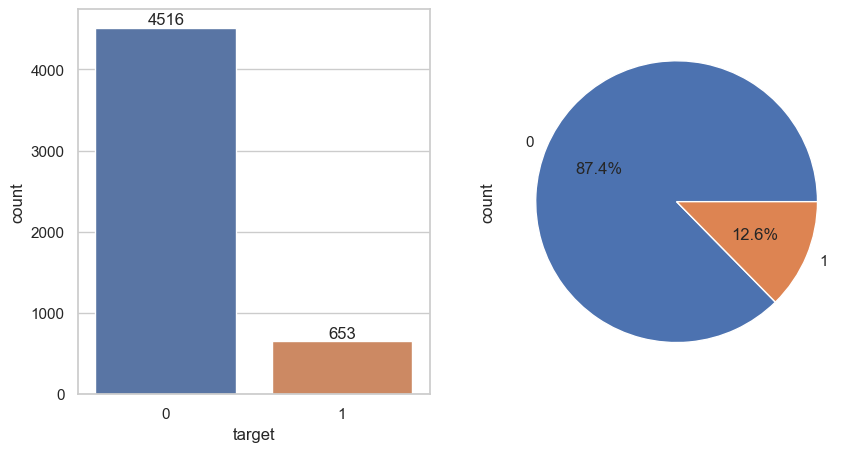

In [10]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plot1 = sns.countplot(df, x='target', ax=ax[0])

# show count number above the bins
for container in plot1.containers:
    plot1.bar_label(container)
    
df.target.value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax[1])

Just 12.6% of the SMS messages in our dataset are classified as spam, whereas 87.4% of the messages are classified as non-spam (ham).   
Recognizing the imbalance, our focus in this classification problem will be on the precision metric. In this context, the worst-case scenario involves classifying a legitimate SMS as spam, making false positives (FP) a critical consideration. Consequently, we prioritize precision to minimize the risk of misclassifying non-spam messages as spam

In [11]:
df['characters_count'] = df['sms'].apply(len)
df.head()

,target,sms,characters_count
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [12]:
df['sentences_count'] = df['sms'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head()

,target,sms,characters_count,sentences_count
0,0,"Go until jurong point, crazy.. Available only ...",111,2
1,0,Ok lar... Joking wif u oni...,29,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,2
3,0,U dun say so early hor... U c already then say...,49,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,1


In [13]:
df['words_count'] = df['sms'].apply(lambda x: len(nltk.word_tokenize(x)))
df.head()

,target,sms,characters_count,sentences_count,words_count
0,0,"Go until jurong point, crazy.. Available only ...",111,2,24
1,0,Ok lar... Joking wif u oni...,29,2,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,2,37
3,0,U dun say so early hor... U c already then say...,49,1,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,1,15


<Axes: xlabel='characters_count', ylabel='Count'>

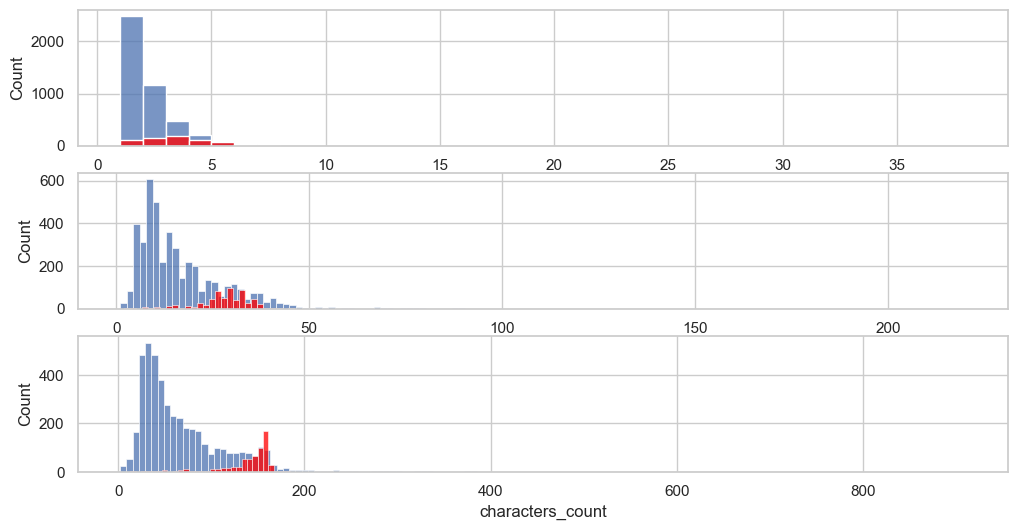

In [14]:
_, ax=plt.subplots(3,1,figsize=(12,6))

sns.histplot(df[df.target==0]['sentences_count'], ax=ax[0], binwidth=1)
sns.histplot(df[df.target==1]['sentences_count'], color='red', ax=ax[0], binwidth=1)

sns.histplot(df[df.target==0]['words_count'], ax=ax[1])
sns.histplot(df[df.target==1]['words_count'], color='red', ax=ax[1])

sns.histplot(df[df.target==0]['characters_count'], ax=ax[2])
sns.histplot(df[df.target==1]['characters_count'], color='red', ax=ax[2])

/home/oussama/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


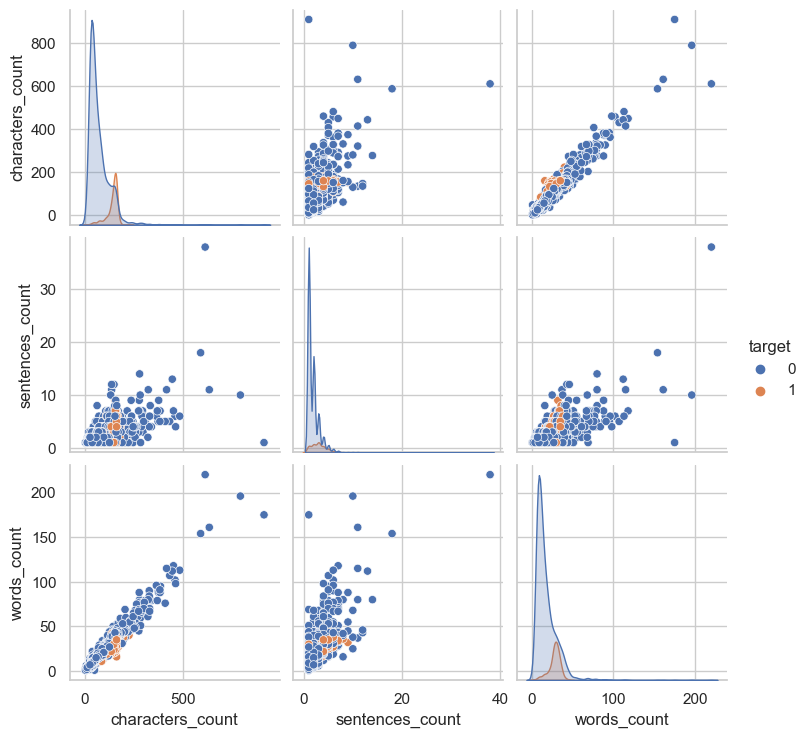

In [15]:
sns.pairplot(df,hue='target')
plt.show()

<Axes: >

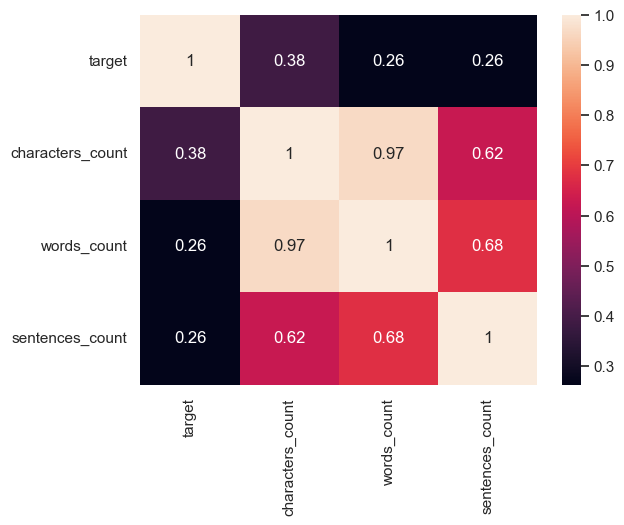

In [16]:
sns.heatmap(df[['target', 'characters_count', 'words_count', 'sentences_count']].corr(),annot=True)

## 🧹 Data Preprocessing:

In [18]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    words = nltk.word_tokenize(text)
    
    # Remove special characters and non-alphanumeric tokens
    words = [word for word in words if word.isalnum()]
    
    # Remove stop words and punctuation
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words and word not in string.punctuation]
    
    # Stemming
    ps = PorterStemmer()
    words = [ps.stem(word) for word in words]
    
    return " ".join(words)

In [19]:
df['text_transformed'] = df['sms'].apply(preprocess_text)
df.head()

,target,sms,characters_count,sentences_count,words_count,text_transformed
0,0,"Go until jurong point, crazy.. Available only ...",111,2,24,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,2,8,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,2,37,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,1,13,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,1,15,nah think goe usf live around though


Let's visualize the most frequently used words in our training dataset for each class. We will be using WordCloud and a helper function to display the most used words in our dataset.

In [25]:
def freq_words(x, n = 30): 
    """
    Helper Function
    Generate a bar plot to visualize the most frequently used n words in a text corpus.

    Parameters:
    - x (list): A list of text documents.
    - terms (int): Number of top words to display in the plot. Default is 30.

    Returns:
    None
    """
    all_words = ' '.join(text for text in x) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 

    d = words_df.nlargest(columns="count", n = n) 

    plt.figure(figsize=(15,6)) 
    sns.barplot(data=d, x= "count", y = "word", palette='dark') 
    plt.show()

In [26]:
wc = WordCloud(width=1000, height=1000, background_color='white', min_font_size=15)

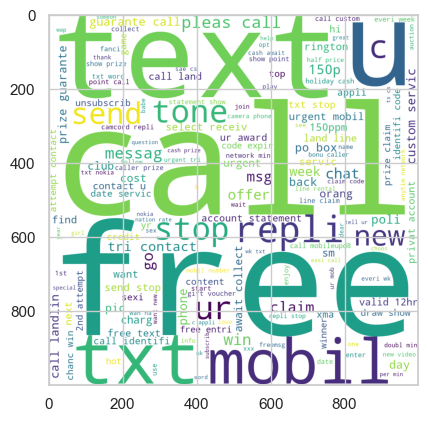

In [27]:
spam_wc = wc.generate(df.loc[df['target'] == 1, 'text_transformed'].str.cat(sep=" "))
plt.imshow(spam_wc)

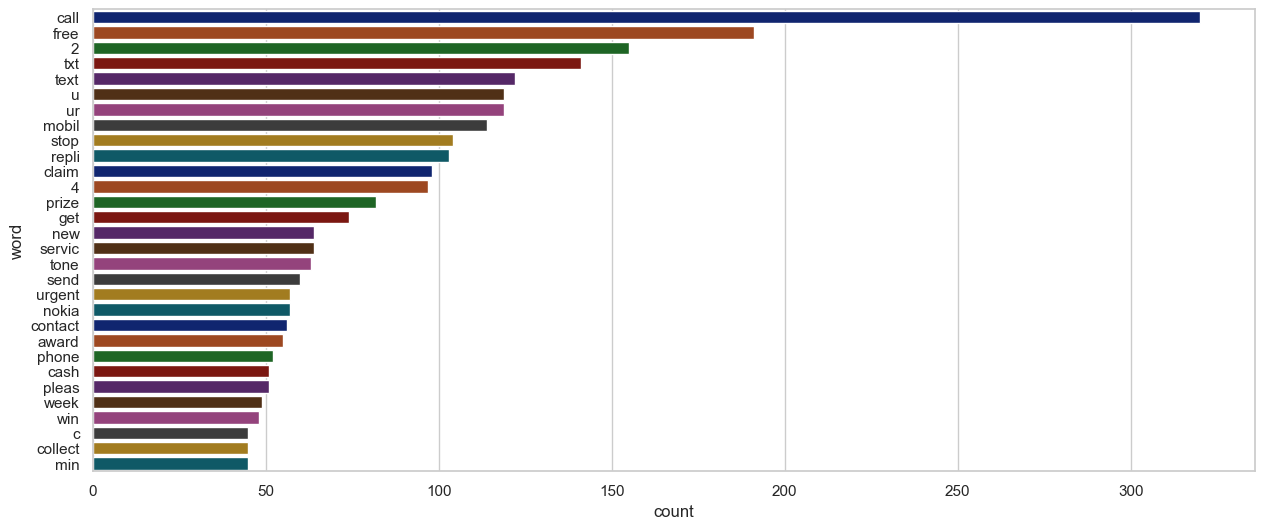

In [28]:
freq_words(df.loc[df['target'] == 1, 'text_transformed'])

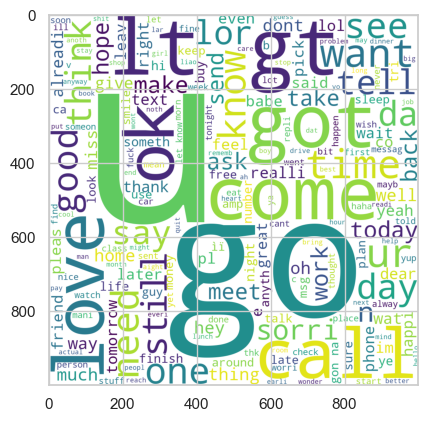

In [29]:
ham_wc = wc.generate(df.loc[df['target'] == 0, 'text_transformed'].str.cat(sep=" "))
plt.imshow(ham_wc)

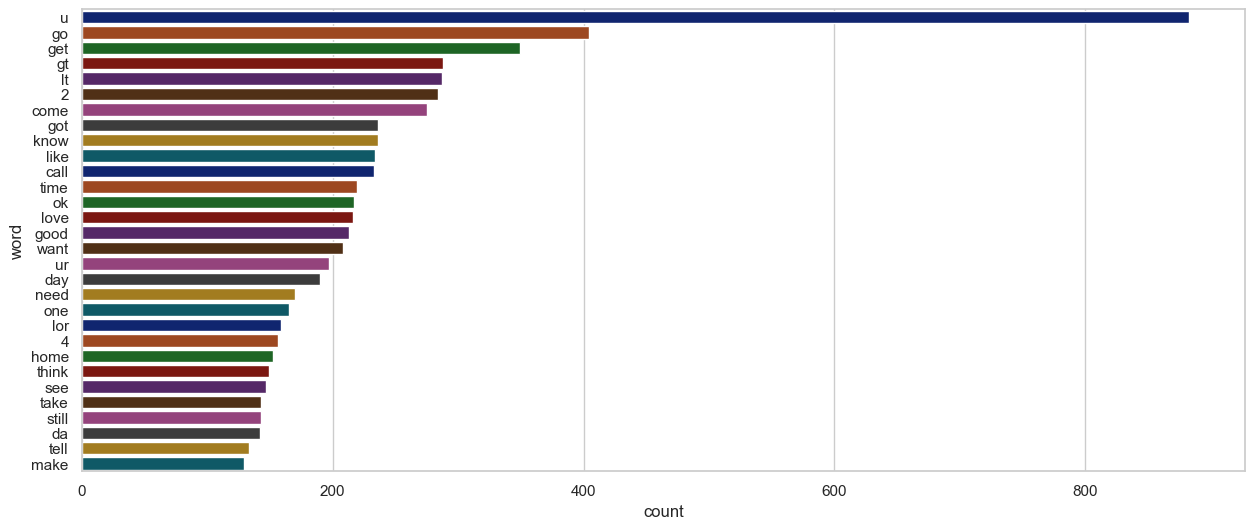

In [30]:
freq_words(df.loc[df['target'] == 0, 'text_transformed'])

## 🤖 Model Building:

For the modeling part, initially, we will use the **`CountVectorizer`** for feature extraction. Additionally, we will employ multiple classifiers such as **`MultinomialNB`** and **`LogisticRegression`**

In [31]:
cv = CountVectorizer()

In [32]:
X = cv.fit_transform(df['text_transformed']).toarray()
y = df['target'].values

X.shape, y.shape

((5169, 6708), (5169,))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((4135, 6708), (1034, 6708))

In [35]:
def test_models(models, X_train, y_train, X_test, y_test):
    """
    Evaluate multiple models and visualize their performance.

    Parameters:
        models (list): List of machine learning models to evaluate.
        X_train, y_train (array-like): Training data.
        X_test, y_test (array-like): Testing data.

    Returns:
        pd.DataFrame: A DataFrame containing accuracy and precision scores for each model.
    """
    scores = {'model': [],
              'accuracy score': [],
              'precision score': []}

    _, ax = plt.subplots(1, len(models), figsize=(20, 5))

    for index, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        model_name = type(model).__name__

        # Append scores to the dictionary
        scores['model'].append(model_name)
        scores['accuracy score'].append(accuracy)
        scores['precision score'].append(precision)

        # Plot confusion matrix
        sns.heatmap(confusion_matrix(y_test, y_pred),cmap='Greens' ,annot=True, ax=ax[index], fmt=".0f")
        ax[index].set_title(model_name)

    scores_df = pd.DataFrame(scores)
    return scores_df

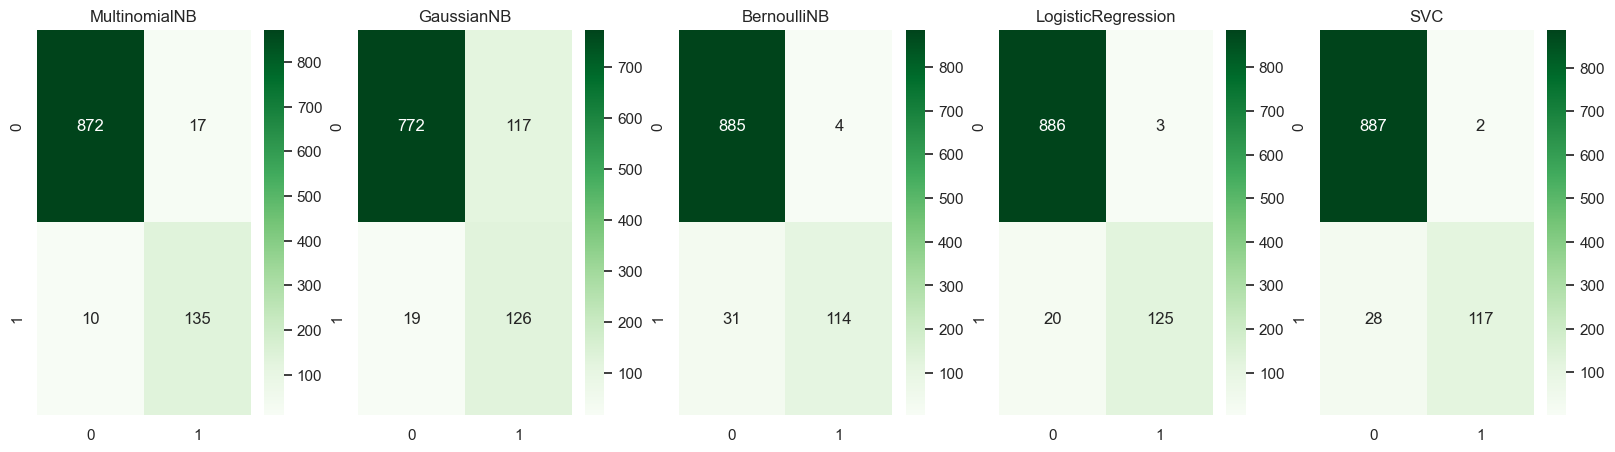

In [36]:
models = [
    MultinomialNB(),
    GaussianNB(),
    BernoulliNB(),
    LogisticRegression(),
    SVC()
]
scores = test_models(models, X_train, y_train, X_test, y_test)

Using CountVectorizer, we observe the following precision and accuracy scores for different classifiers:

In [37]:
scores

,model,accuracy score,precision score
0,MultinomialNB,0.973888,0.888158
1,GaussianNB,0.868472,0.518519
2,BernoulliNB,0.966151,0.966102
3,LogisticRegression,0.977756,0.976562
4,SVC,0.970986,0.983193


Notably, the Support Vector Classifier (SVC) achieves the highest precision among the classifiers evaluated.

In [38]:
def plot_scores(scores, title="Model Comparison: Accuracy and Precision"):
    scores_melted = scores.melt(id_vars='model', var_name='metric', value_name='score')
    # Plotting accuracy and precision in the same plot
    plt.figure(figsize=(14, 8))
    sns.barplot(x='model', y='score', hue='metric', data=scores_melted, palette='viridis')
    plt.title(title)
    plt.ylim(0, 1.1)  # Set the y-axis limit between 0 and 1
    plt.legend(title='Metric', loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.show()

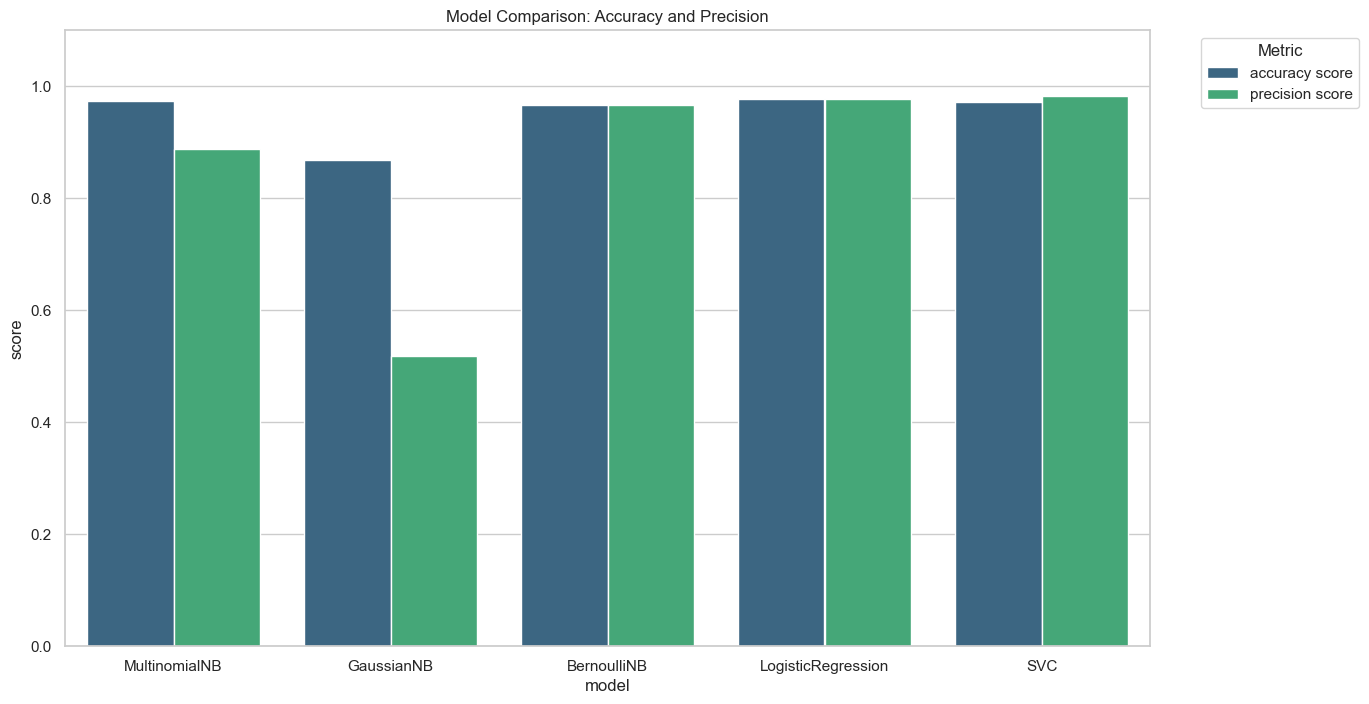

In [39]:
plot_scores(scores)

Now, let's explore the performance by using the **`TfidfVectorizer`** for feature extraction with the same set of classifiers

In [40]:
tfidf = TfidfVectorizer(max_features=4000)

In [41]:
X = tfidf.fit_transform(df['text_transformed']).toarray()
y = df['target'].values

X.shape, y.shape

((5169, 4000), (5169,))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((4135, 4000), (1034, 4000))

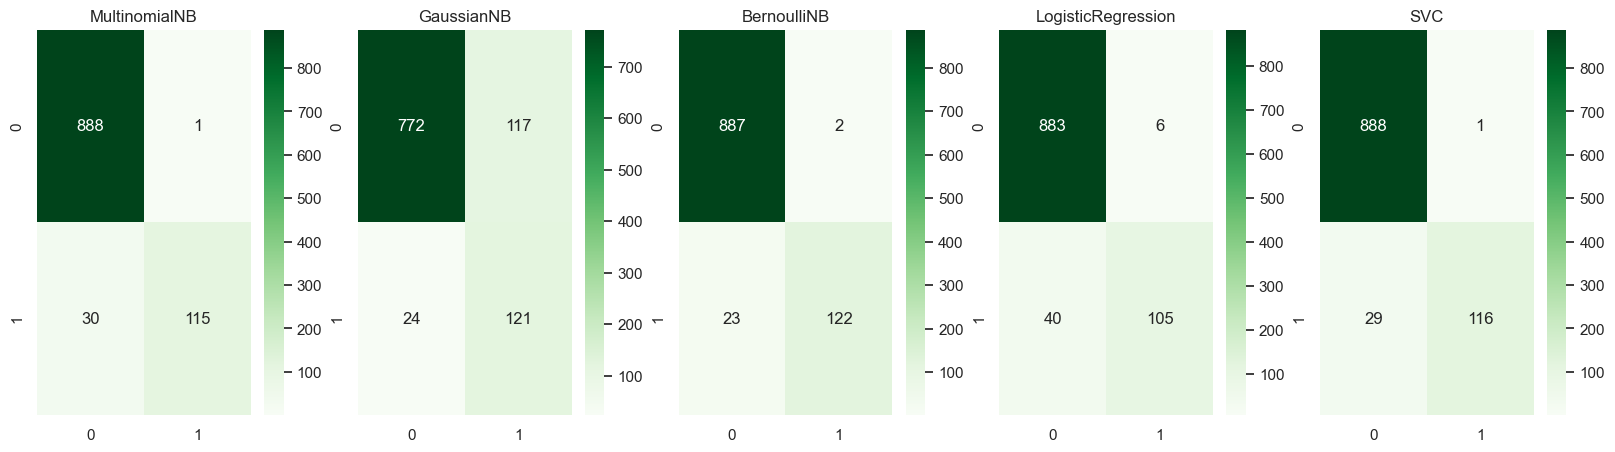

In [43]:
scores = test_models(models, X_train, y_train, X_test, y_test)

In [44]:
scores

,model,accuracy score,precision score
0,MultinomialNB,0.970019,0.991379
1,GaussianNB,0.863636,0.508403
2,BernoulliNB,0.975822,0.983871
3,LogisticRegression,0.955513,0.945946
4,SVC,0.970986,0.991453


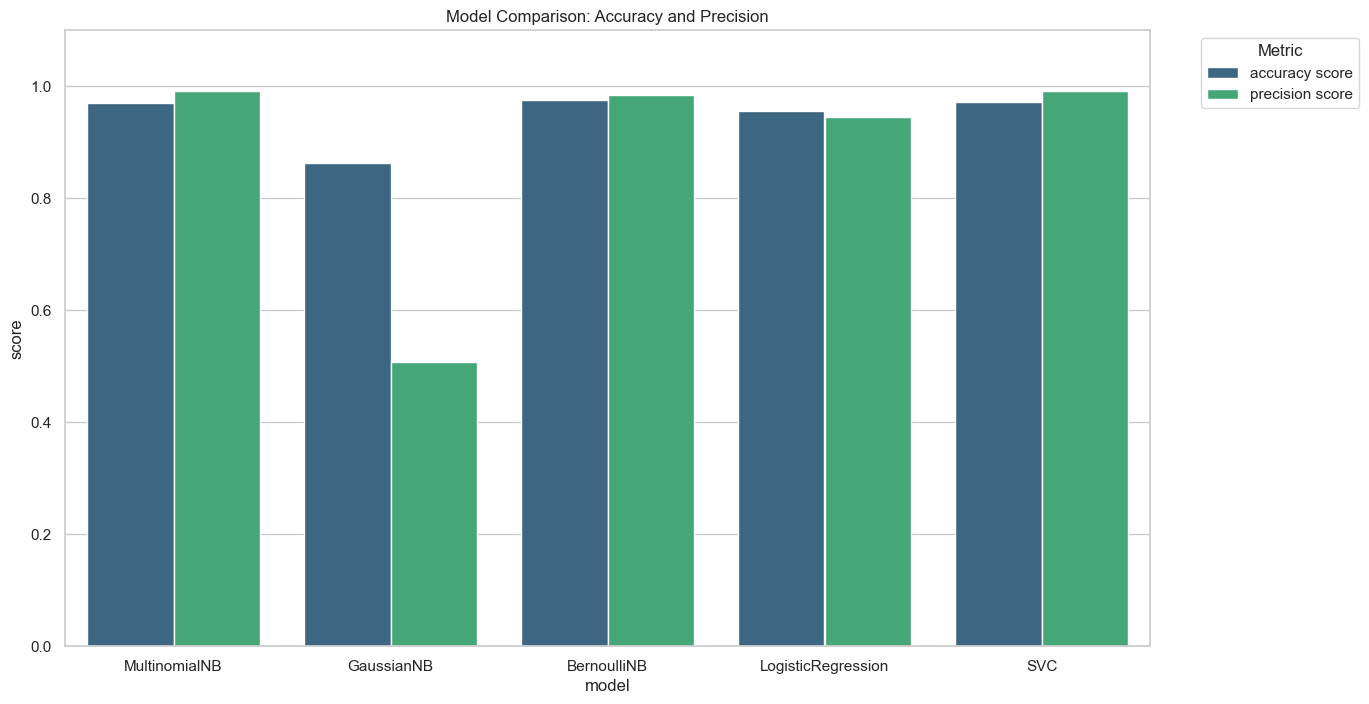

In [149]:
plot_scores(scores)

Significantly, MultinomialNB and SVC demonstrate notable precision

## 📊 Results and Conclusion

In summary, our investigation of feature extraction techniques, specifically comparing CountVectorizer and TfidfVectorizer, reveals that using the TfidfVectorizer, particularly with the Support Vector Classifier (SVC), yields superior performance.